<a href="https://colab.research.google.com/github/kartikey-chauhan/Crack-detection-using-Resnet18-PyTorch/blob/main/Pytorch_Resnet18_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Resnet18  Classifier with PyTorch </h1>


In [1]:
#!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P /resources/data

In [2]:
#!unzip -q  /resources/data/concrete_crack_images_for_classification.zip -d  /resources/data

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import *
import torchvision
from tqdm import tqdm
import torch.nn as nn
import numpy as np
from torch import optim 

In [4]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
use_cuda

True

<h2 id="data_class">Dataset Class</h2>


In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  If the parameter <code>train</code> is set to <code>True</code>, use the first 30 000  samples as training data; otherwise, the remaining samples will be used as validation data. 


In [5]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>


We create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>.


In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

We create objects for the training data  <code>dataset_train</code> and validation <code>dataset_val</code> and use the transform object to convert the images to tensors using the transform object


In [7]:
dataset_train=Dataset(transform=transform,train=True)
dataset_val=Dataset(transform=transform,train=False)

We  can find the shape of the image


In [8]:
dataset_train[0][0].shape

torch.Size([3, 227, 227])

We see that it's a color image with three channels


## Hyperparameters

<b>Parameter Values</b>

   <li>learning rate:0.001 </li>
   <li>batch size training:128</li>
   <li>Loss function:Stochastic Gradient Descent </li>
   <li>epochs:5</li>
   <li>set: torch.manual_seed(0)</li>


In [10]:
torch.manual_seed(0)

<b>We use the resnet18 model from torchvision library</b>


In [18]:
model = models.resnet18(pretrained=True)
# move model to GPU if CUDA is available
if use_cuda:
    model = model.cuda()

<b>Model Object:</b>


In [12]:
#keep the convolutional part fixed
for param in model.parameters():
  param.requires_grad=False
model.fc=nn.Linear(512,2)

<b>Optimizer:</b>


In [21]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

<b>Criterion:</b>


In [14]:
criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>


In [15]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=128)
validation_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=128)

images-size: torch.Size([128, 3, 227, 227])
out-size: torch.Size([3, 3666, 1834])


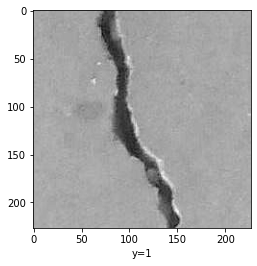

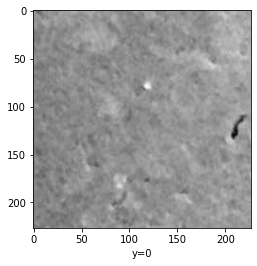

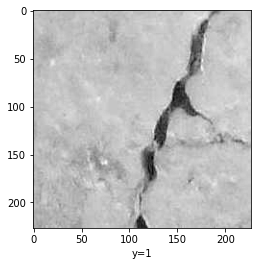

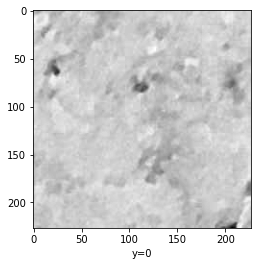

In [70]:
def show_data(images,labels):
    plt.imshow(images[0], cmap='gray')
    plt.xlabel("y="+str(labels.item()))
    plt.show()

images, labels = next(iter(train_loader)) 
print("images-size:", images.shape)
out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

# plot our first five training samples
for a,b in zip(images[:4],labels[:4]):
  show_data(a,b)

**Train Model with 5 epochs**

In [22]:
n_epochs = 5
loss_list = []
accuracy_list = []
total_step = len(train_loader)
valid_loss_min = np.Inf
N_test = len(dataset_val)

def train_model(n_epochs):
    global valid_loss_min
    for epoch in range(1, n_epochs+1):
        print(f'Epoch {epoch}\n')
        for batch_idx, (x, y) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
              x, y = x.cuda(), y.cuda()
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            if (batch_idx) % 20 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))   
        correct = 0
        batch_loss = 0
        # perform a prediction on the validation data  
        with torch.no_grad():
          model.eval()
          for x_test, y_test in validation_loader:
              model.eval()
              if use_cuda:
                x_test, y_test = x_test.cuda(), y_test.cuda()
              z = model(x_test)
              loss_t = criterion(z, y_test)
              batch_loss += loss_t.item()
              _, yhat = torch.max(z.data, 1)
              correct += (yhat == y_test).sum().item()
          accuracy = correct / N_test
          loss_list.append(loss_t.data)
          accuracy_list.append(accuracy)
          network_learned = batch_loss < valid_loss_min
          #save model parameters if the loss is reduced, marking an improvement
          if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')

train_model(n_epochs)

Epoch 1

Epoch [1/5], Step [0/235], Loss: 9.1057
Epoch [1/5], Step [20/235], Loss: 2.6882
Epoch [1/5], Step [40/235], Loss: 0.5903
Epoch [1/5], Step [60/235], Loss: 0.2620
Epoch [1/5], Step [80/235], Loss: 0.1514
Epoch [1/5], Step [100/235], Loss: 0.1088
Epoch [1/5], Step [120/235], Loss: 0.0982
Epoch [1/5], Step [140/235], Loss: 0.0752
Epoch [1/5], Step [160/235], Loss: 0.0673
Epoch [1/5], Step [180/235], Loss: 0.0407
Epoch [1/5], Step [200/235], Loss: 0.0493
Epoch [1/5], Step [220/235], Loss: 0.0822
Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/235], Loss: 0.1053
Epoch [2/5], Step [20/235], Loss: 0.0171
Epoch [2/5], Step [40/235], Loss: 0.0126
Epoch [2/5], Step [60/235], Loss: 0.0300
Epoch [2/5], Step [80/235], Loss: 0.0204
Epoch [2/5], Step [100/235], Loss: 0.0206
Epoch [2/5], Step [120/235], Loss: 0.0286
Epoch [2/5], Step [140/235], Loss: 0.0124
Epoch [2/5], Step [160/235], Loss: 0.0411
Epoch [2/5], Step [180/235], Loss: 0.0125
Epoch [2/5], Step [200/235], Loss: 0.

** Plot the loss and accuracy**

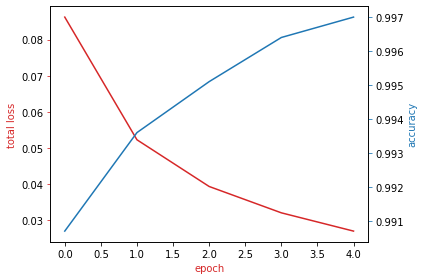

In [23]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

Above figure shows our model's inverse relationship between loss and accuracy.

**Plot the first 5 mis-classified samples**

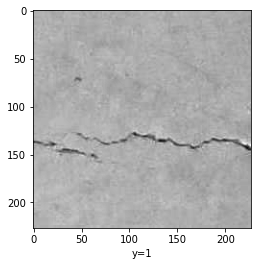

Model Output:  0


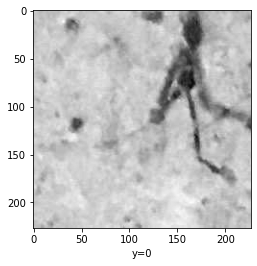

Model Output:  1


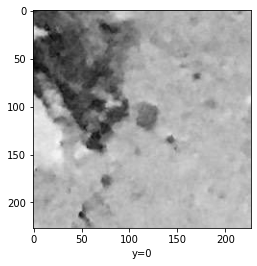

Model Output:  1


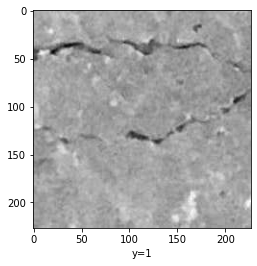

Model Output:  0


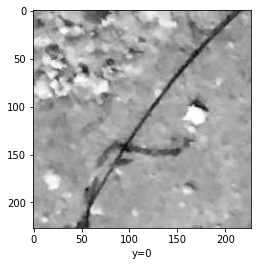

Model Output:  1


In [77]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=dataset_val, batch_size=1):
    if use_cuda:
      x, y = x.cuda(), y.cuda()
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat.item() != y.item():
        show_data(x.cpu()[0],y.cpu()[0])
        print("Model Output: ",yhat.item())
        count += 1
    if count >= 5:
        break